in this file a potenitla api is developed for the tramdag 

## TRAM Config

In [ ]:
from utils.configuration import *

class TramDagConfig:
    def __init__(self, conf_dict: dict = None, CONF_DICT_PATH: str = None, **kwargs):
        """
        Initialize TramDagConfig.

        Args:
            conf_dict: optional dict with configuration. If None, starts empty.
            CONF_DICT_PATH: optional path to config file.
        """
        #TODO add verbose and debug , vebose print only infos, debug prints info + debug statements, warnings, errors are always printed
        #TODO add veryfier such that nothing is missing for later training such as experiment name 
        
        self.debug = False
        self.verbose = False
        
        for key, value in kwargs.items():
            if key in ['conf_dict', 'CONF_DICT_PATH']:
                raise ValueError(f"Cannot override '{key}' via kwargs.")
            setattr(self, key, value)
        
        self.conf_dict = conf_dict or {}
        self.CONF_DICT_PATH = CONF_DICT_PATH
        
        # verification 
        self._verify_completeness()

    @classmethod
    def load(cls, CONF_DICT_PATH: str,debug: bool = False):
        """
        Alternative constructor: load config directly from a file.
        """
        conf = load_configuration_dict(CONF_DICT_PATH)
        return cls(conf, CONF_DICT_PATH=CONF_DICT_PATH,debug=debug)

    def save(self, CONF_DICT_PATH: str = None):
        """
        Save config to file. If path is not provided, fall back to stored path.
        """
        path = CONF_DICT_PATH or self.CONF_DICT_PATH
        if path is None:
            raise ValueError("No CONF_DICT_PATH provided to save config.")
        write_configuration_dict(self.conf_dict, path)

    def _verify_completeness(self):
        """
        Verify that the configuration is complete and consistent:
        - All mandatory keys exist
        - Mandatory keys have valid values
        - Optional keys (if present) are valid
        """
        mandatory_keys = ["experiment_name","PATHS", "nodes", "data_type", "adj_matrix","nodes","model_names"]
        optional_keys = ["date_of_creation", "seed"]

        # ---- 1. Check mandatory keys exist
        missing = [k for k in mandatory_keys if k not in self.conf_dict]
        if missing:
            print(f"[WARNING] Missing mandatory keys in configuration: {missing}"
                "\n Please add them to the configuration dict and reload.")
            
        # --- 2. Check  if mandatory keys in nodesdict are present
        mandatory_keys_nodes = ['data_type', 'node_type','parents','parents_datatype','transformation_terms_in_h()','transformation_term_nn_models_in_h()']
        optional_keys_nodes = ["levels"]
        for node, node_dict in self.conf_dict.get("nodes", {}).items():
            # check missing mandatory keys
            missing_node_keys = [k for k in mandatory_keys_nodes if k not in node_dict]
            if missing_node_keys:
                print(f"[WARNING] Node '{node}' is missing mandatory keys: {missing_node_keys}")
                

        
        if self._verify_levels_dict():
            if self.debug:
                print("[DEBUG] levels are present for all ordinal variables in configuration dict.")
            pass
        else:
            print("[WARNING] levels are missing for some ordinal variables in configuration dict. THIS will FAIL in model training later!\n"
                " Please provide levels manually to config and reload or compute levels from data using the method compute_levels().\n"
                " e.g. cfg.compute_levels(train_df) # computes levels from training data and writes to cfg")

        if self._verify_experiment_name():
            if self.debug:
                print("[DEBUG] experiment_name is valid in configuration dict.")
            pass
        
        if self._verify_adj_matrix():
            if self.debug:
                print("[DEBUG] adj_matrix is valid in configuration dict.")
            pass

    def _verify_levels_dict(self):
        """
        Verify that levels_dict is present for all categorical variables.
        """
        data_type = self.conf_dict.get('data_type', {})
        nodes = self.conf_dict.get('nodes', {})
        for var, dtype in data_type.items():
            if 'ordinal' in dtype:
                if var not in nodes or 'levels' not in nodes[var]:
                    return False
        return True

    def _verify_experiment_name(self):
        experiment_name = self.conf_dict.get("experiment_name")
        if experiment_name is None or str(experiment_name).strip() == "":
            return False
        return True
        
    def _verify_adj_matrix(self):
        adj_matrix = self.conf_dict['adj_matrix']
        if isinstance(adj_matrix, list):
            adj_matrix = np.array(self.conf_dict['adj_matrix'])
        if validate_adj_matrix(adj_matrix):
            return True
        else:
            return False
        
    def compute_levels(self, df: pd.DataFrame, write: bool = True):
        """
        Derive levels information from data and update configuration dict.
        """
        levels_dict = create_levels_dict(df, self.conf_dict['data_type'])
        
        # update nodes dict with levels
        for var, levels in levels_dict.items():
            if var in self.conf_dict['nodes']:
                self.conf_dict['nodes'][var]['levels'] = levels
            else:
                print(f"[WARNING] Variable '{var}' not found in nodes dict. Cannot add levels.")
        
        if write and self.CONF_DICT_PATH is not None:
            try:
                self.save(self.CONF_DICT_PATH)
                if self.verbose or self.debug:
                    print(f'[INFO] Configuration with updated levels saved to {self.CONF_DICT_PATH}')
            except Exception as e:
                print(f'[ERROR] Failed to save configuration: {e}')

    def plot_dag(self, seed: int = 42, use_spring: bool = True):
        """
        Plot the DAG with Source, Sink, and Intermediate nodes.

        Parameters
        ----------
        seed : int, default=42
            Random seed for layout stability.
        use_spring : bool, default=True
            If True use networkx.spring_layout; 
            if False try Graphviz “dot” (falls back to spring).
        """
        adj_matrix = self.conf_dict.get("adj_matrix")
        data_type  = self.conf_dict.get("data_type")

        if adj_matrix is None or data_type is None:
            raise ValueError("Configuration must include 'adj_matrix' and 'data_type'.")

        # convert list to numpy if needed
        if isinstance(adj_matrix, list):
            adj_matrix = np.array(adj_matrix)

        if not validate_adj_matrix(adj_matrix):
            raise ValueError("Invalid adjacency matrix.")
        if len(data_type) != adj_matrix.shape[0]:
            raise ValueError("data_type must match adjacency matrix size.")

        node_labels = list(data_type.keys())
        G, edge_labels = create_nx_graph(adj_matrix, node_labels)

        # classify nodes
        sources       = {n for n in G.nodes if G.in_degree(n) == 0}
        sinks         = {n for n in G.nodes if G.out_degree(n) == 0}
        intermediates = set(G.nodes) - sources - sinks

        # assign node colors
        node_colors = [
            "green" if n in sources
            else "red" if n in sinks
            else "lightblue"
            for n in G.nodes
        ]

        # choose layout
        if use_spring:
            pos = nx.spring_layout(G, seed=seed, k=1.5, iterations=100)
        else:
            try:
                pos = nx.nx_agraph.graphviz_layout(G, prog="dot")
            except (ImportError, nx.NetworkXException):
                pos = nx.spring_layout(G, seed=seed, k=1.5, iterations=100)

        # draw nodes and edges
        plt.figure(figsize=(8, 6))
        nx.draw(
            G, pos,
            with_labels=True,
            node_color=node_colors,
            edge_color="gray",
            node_size=2500,
            arrowsize=20
        )

        # draw edge labels colored by prefix
        for (u, v), lbl in edge_labels.items():
            color = (
                "blue"  if lbl.startswith("ci")
                else "red"   if lbl.startswith("ls")
                else "green" if lbl.startswith("cs")
                else "black"
            )
            nx.draw_networkx_edge_labels(
                G, pos,
                edge_labels={(u, v): lbl},
                font_color=color,
                font_size=12
            )

        # build legend
        legend_items = [
            Patch(facecolor="green",     edgecolor="black", label="Source"),
            Patch(facecolor="red",       edgecolor="black", label="Sink"),
            Patch(facecolor="lightblue", edgecolor="black", label="Intermediate")
        ]
        plt.legend(handles=legend_items, loc="upper right", frameon=True)

        plt.title("TRAM DAG")
        plt.axis("off")
        plt.tight_layout()
        plt.show()


# TramDagDataset

In [ ]:
import inspect
from utils.tram_data import GenericDataset
from torch.utils.data import Dataset, DataLoader
class TramDagDataset(Dataset):
    
    DEFAULTS = {
        "batch_size": 32,
        "shuffle": True,
        "num_workers": 4,
        "pin_memory": False,
        "return_intercept_shift": True,
        "debug": False,
        "transform": None,
        "use_dataloader": True,
    }

    def __init__(self):
        """Empty init. Use classmethods like .from_dataframe()."""
        pass

    @classmethod
    def from_dataframe(cls, df, cfg, **kwargs):
        self = cls()
        if not isinstance(df, pd.DataFrame):
            raise TypeError(f"[ERROR] df must be a pandas DataFrame, but got {type(df)}")

        # merge defaults with overrides
        settings = dict(cls.DEFAULTS)
        settings.update(kwargs)

        # infer variable name automatically
        callers_locals = inspect.currentframe().f_back.f_locals
        inferred = None
        for var_name, var_val in callers_locals.items():
            if var_val is df:
                inferred = var_name
                break
        df_name = inferred or "dataframe"

        if settings["shuffle"]:
            if any(x in df_name.lower() for x in ["val", "validation", "test"]):
                print(f"[WARNING] DataFrame '{df_name}' looks like a validation/test set → shuffle=True. Are you sure?")

        self.cfg = cfg
        self.df = df.copy()
        self._apply_settings(settings)
        self._build_dataloaders()
        return self

    def compute_scaling(self, df: pd.DataFrame=None, write: bool = True):
        """
        Derive scaling information (min, max, levels) from data USE training data.
        """
        if self.debug:
            print("[DEBUG] Make sure to provide only training data to compute_scaling!")     
        if df is None:
            df = self.df
            if self.debug:
                print("[DEBUG] No DataFrame provided, using internal df.")
        quantiles = df.quantile([0.05, 0.95])
        min_vals = quantiles.loc[0.05]
        max_vals = quantiles.loc[0.95]
        minmax_dict = pd.concat([min_vals, max_vals], axis=1).T.to_dict('list')
        return minmax_dict

    def _apply_settings(self, settings: dict):
        self.batch_size = settings["batch_size"]
        self.shuffle = settings["shuffle"]
        self.num_workers = settings["num_workers"]
        self.pin_memory = settings["pin_memory"]
        self.return_intercept_shift = settings["return_intercept_shift"]
        self.debug = settings["debug"]
        self.transform = settings["transform"]
        self.use_dataloader = settings["use_dataloader"]   
        self.nodes_dict = self.cfg.conf_dict["nodes"]

        # validate dict attributes
        for name, val in {
            "batch_size": self.batch_size,
            "shuffle": self.shuffle,
            "num_workers": self.num_workers,
            "pin_memory": self.pin_memory,
            "return_intercept_shift": self.return_intercept_shift,
            "debug": self.debug,
            "transform": self.transform,
        }.items():
            self._check_keys(name, val)

    def _build_dataloaders(self):
        """Build node-specific dataloaders or raw datasets depending on settings."""
        self.loaders = {}
        for node in self.nodes_dict:
            ds = GenericDataset(
                self.df,
                target_col=node,
                target_nodes=self.nodes_dict,
                transform=self.transform if not isinstance(self.transform, dict) else self.transform[node],
                return_intercept_shift=self.return_intercept_shift if not isinstance(self.return_intercept_shift, dict) else self.return_intercept_shift[node],
                debug=self.debug if not isinstance(self.debug, dict) else self.debug[node],
            )

            if self.use_dataloader:
                batch_size = self.batch_size[node] if isinstance(self.batch_size, dict) else self.batch_size
                shuffle_flag = self.shuffle[node] if isinstance(self.shuffle, dict) else bool(self.shuffle)
                num_workers = self.num_workers[node] if isinstance(self.num_workers, dict) else self.num_workers
                pin_memory = self.pin_memory[node] if isinstance(self.pin_memory, dict) else self.pin_memory

                self.loaders[node] = DataLoader(
                    ds,
                    batch_size=batch_size,
                    shuffle=shuffle_flag,
                    num_workers=num_workers,
                    pin_memory=pin_memory,
                )
            else:
                # just keep raw dataset
                self.loaders[node] = ds

    def _check_keys(self, attr_name, attr_value):
        """Check if dict keys match cfg.conf_dict['nodes'].keys()."""
        if isinstance(attr_value, dict):
            expected_keys = set(self.nodes_dict.keys())
            given_keys = set(attr_value.keys())
            if expected_keys != given_keys:
                raise ValueError(
                    f"[ERROR] the provided attribute '{attr_name}' keys are not same as in cfg.conf_dict['nodes'].keys().\n"
                    f"Expected: {expected_keys}, but got: {given_keys}\n"
                    f"Please provide values for all variables."
                )

    def summary(self):
        print("\n[TramDagDataset Summary]")
        print("=" * 60)

        # ---- DataFrame section ----
        print("\n[DataFrame]")
        print("Shape:", self.df.shape)
        print("\nHead:")
        print(self.df.head())

        print("\nDtypes:")
        print(self.df.dtypes)

        print("\nDescribe:")
        print(self.df.describe(include="all"))

        # ---- Settings per node ----
        print("\n[Node Settings]")
        for node in self.nodes_dict.keys():
            batch_size = self.batch_size[node] if isinstance(self.batch_size, dict) else self.batch_size
            shuffle_flag = self.shuffle[node] if isinstance(self.shuffle, dict) else bool(self.shuffle)
            num_workers = self.num_workers[node] if isinstance(self.num_workers, dict) else self.num_workers
            pin_memory = self.pin_memory[node] if isinstance(self.pin_memory, dict) else self.pin_memory
            rshift = self.return_intercept_shift[node] if isinstance(self.return_intercept_shift, dict) else self.return_intercept_shift
            debug_flag = self.debug[node] if isinstance(self.debug, dict) else self.debug
            transform = self.transform[node] if isinstance(self.transform, dict) else self.transform

            print(
                f" Node '{node}': "
                f"batch_size={batch_size}, "
                f"shuffle={shuffle_flag}, "
                f"num_workers={num_workers}, "
                f"pin_memory={pin_memory}, "
                f"return_intercept_shift={rshift}, "
                f"debug={debug_flag}, "
                f"transform={transform}"
            )
        print("=" * 60 + "\n")

    def __getitem__(self, idx):
        return self.df.iloc[idx].to_dict()

    def __len__(self):
        return len(self.df)


# TramDagModel

In [ ]:
from utils.tram_model_helpers import train_val_loop, get_fully_specified_tram_model 
from utils.tram_data_helpers import create_latent_df_for_full_dag, sample_full_dag,is_outcome_modelled_ordinal,is_outcome_modelled_continous
from torch.optim import Adam
import torch
import os


class TramDagModel:
    
    #TODO add docstring
    # ---- defaults used at construction time ----
    DEFAULTS_CONFIG = {
        "set_initial_weights": False,
        "debug":False,
        
    }

    # ---- defaults used at fit() time ----
    DEFAULTS_FIT = {
        "epochs": 100,
        "train_list": None,
        "callbacks": None,
        "learning_rate": 0.01,
        "device": "auto",
        "optimizers": None,
        "schedulers": None,
        "use_scheduler": False,
        "save_linear_shifts": True,
        "debug":False,
        "verbose": True,
    }

    def __init__(self):
        """Empty init. Use classmethods like .from_config()."""
        self.debug = False
        self.verbose = False
        self.device = None
        pass

    @classmethod
    def from_config(cls, cfg, **kwargs):
        """
        Build one TramModel per node based on configuration and kwargs.
        Kwargs can be scalars (applied to all nodes) or dicts {node: value}.
        """
        self = cls()
        self.cfg = cfg
        self.nodes_dict = self.cfg.conf_dict["nodes"] 

        # resolve device
        device_arg = kwargs.get("device", "auto")
        if device_arg == "auto":
            device_str = "cuda" if torch.cuda.is_available() else "cpu"
        else:
            device_str = device_arg
        self.device = torch.device(device_str)
            
        # merge defaults with user overrides
        settings = dict(cls.DEFAULTS_CONFIG)
        settings.update(kwargs)

        # set flags on the instance so they are accessible later
        self.debug = settings.get("debug", False)
        self.verbose = settings.get("verbose", False)

        if  self.debug:
            print(f"[DEBUG] TramDagModel using device: {self.device}")
            
        # initialize settings storage
        self.settings = {k: {} for k in settings.keys()}

        # validate dict-typed args
        for k, v in settings.items():
            if isinstance(v, dict):
                expected = set(self.nodes_dict.keys())
                given = set(v.keys())
                if expected != given:
                    raise ValueError(
                        f"[ERROR] the provided argument '{k}' keys are not same as in cfg.conf_dict['nodes'].keys().\n"
                        f"Expected: {expected}, but got: {given}\n"
                        f"Please provide values for all variables."
                    )

        # build one model per node
        self.models = {}
        for node in self.nodes_dict.keys():
            per_node_kwargs = {}
            for k, v in settings.items():
                if k == "device":   # skip device, not for get_fully_specified_tram_model
                    continue
                resolved = v[node] if isinstance(v, dict) else v
                per_node_kwargs[k] = resolved
                self.settings[k][node] = resolved
            if self.debug:
                print(f"\n[INFO] Building model for node '{node}' with settings: {per_node_kwargs}")
            self.models[node] = get_fully_specified_tram_model(
                node=node,
                configuration_dict=self.cfg.conf_dict,
                **per_node_kwargs
            )
        return self

    @classmethod
    def from_directory(cls, EXPERIMENT_DIR: str, device: str = "auto", debug: bool = False, verbose: bool = False):
        """
        Reconstruct a TramDagModel from an experiment directory.

        This loads:
        - The configuration file (config.json).
        - The minmax scaling file (min_max_scaling.json).
        - Initializes all per-node models (like from_config).

        Parameters
        ----------
        experiment_dir : str
            Path to the experiment directory containing `config.json` and `min_max_scaling.json`.
        device : str, optional
            Device string ("cpu", "cuda", or "auto"). Default is "auto".
        debug : bool, optional
            Enable debug printing. Default = False.
        verbose : bool, optional
            Enable info printing. Default = True.

        Returns
        -------
        TramDagModel
            A fully initialized TramDagModel with config and minmax loaded.
        """

        # --- load config file ---
        config_path = os.path.join(EXPERIMENT_DIR, "configuration.json")
        if not os.path.exists(config_path):
            raise FileNotFoundError(f"[ERROR] Config file not found at {config_path}")

        with open(config_path, "r") as f:
            cfg_dict = json.load(f)

        # Create TramConfig wrapper (adjust if your cfg is a dict already)
        cfg = TramDagConfig(cfg_dict)

        # --- build model from config ---
        self = cls.from_config(cfg, device=device, debug=debug, verbose=verbose)

        # --- load minmax scaling ---
        minmax_path = os.path.join(EXPERIMENT_DIR, "min_max_scaling.json")
        if not os.path.exists(minmax_path):
            raise FileNotFoundError(f"[ERROR] MinMax file not found at {minmax_path}")

        with open(minmax_path, "r") as f:
            self.minmax_dict = json.load(f)

        if self.verbose or self.debug:
            print(f"[INFO] Loaded TramDagModel from {EXPERIMENT_DIR}")
            print(f"[INFO] Config loaded from {config_path}")
            print(f"[INFO] MinMax scaling loaded from {minmax_path}")

        return self

    def load_or_compute_minmax(self, use_existing=False, write=True,td_train_data=None):
        EXPERIMENT_DIR = self.cfg.conf_dict["PATHS"]["EXPERIMENT_DIR"]
        minmax_path = os.path.join(EXPERIMENT_DIR, "min_max_scaling.json")

        # laod exisitng if possible
        if use_existing:
            if not os.path.exists(minmax_path):
                raise FileNotFoundError(f"MinMax file not found: {minmax_path}")
            try:
                with open(minmax_path, 'r') as f:
                    self.minmax_dict = json.load(f)
                if self.debug or self.verbose:
                    print(f"[INFO] Loaded existing minmax dict from {minmax_path}")
                return
            except Exception as e:
                raise RuntimeError(f"Could not load existing minmax dict: {e}")

        # 
        if self.debug or self.verbose:
            print("[INFO] Computing new minmax dict from training data...")
        self.minmax_dict = td_train_data.compute_scaling()

        if write:
            os.makedirs(EXPERIMENT_DIR, exist_ok=True)
            with open(minmax_path, 'w') as f:
                json.dump(self.minmax_dict, f, indent=4)
            if self.debug or self.verbose:
                print(f"[INFO] Saved new minmax dict to {minmax_path}")

    def fit(self, train_data, val_data=None, **kwargs):
        """
        Fit TRAM models for specified nodes.

        Parameters
        ----------
        train_data : pd.DataFrame or TramDagDataset
            Training data, either as a raw dataframe or as a TramDagDataset.
        val_data : pd.DataFrame or TramDagDataset, optional
            Validation data, either as a raw dataframe or as a TramDagDataset.
        kwargs : dict
            Overrides for DEFAULTS_FIT (epochs, learning_rate, device, etc.).
        """

        # --- convert to TramDagDataset if needed ---
        if isinstance(train_data, pd.DataFrame):
            td_train_data = TramDagDataset.from_dataframe(train_data, self.cfg)
        elif isinstance(train_data, TramDagDataset):
            td_train_data = train_data
        else:
            raise TypeError(
                f"[ERROR] train_data must be pd.DataFrame or TramDagDataset, got {type(train_data)}"
            )

        if isinstance(val_data, pd.DataFrame):
            td_val_data = TramDagDataset.from_dataframe(val_data, self.cfg, shuffle=False)
        elif isinstance(val_data, TramDagDataset):
            td_val_data = val_data
        elif val_data is None:
            td_val_data = None
        else:
            raise TypeError(
                f"[ERROR] val_data must be pd.DataFrame, TramDagDataset, or None, got {type(val_data)}"
            )

        # --- merge defaults with overrides ---
        settings = dict(self.DEFAULTS_FIT)
        settings.update(kwargs)

        # --- resolve device ---
        device_arg = settings.get("device", "auto")
        if device_arg == "auto":
            device_str = "cuda" if torch.cuda.is_available() else "cpu"
        else:
            device_str = device_arg
        self.device = torch.device(device_str)
        device = self.device

        # which nodes to train , default all nodes
        train_list = settings["train_list"] or list(self.models.keys())

        def _resolve(key, node):
            val = settings[key]
            return val[node] if isinstance(val, dict) else val

        # store resolved settings for this fit
        self.fit_settings = {k: {} for k in settings.keys()}

        # calculate scaling from training data and write to EXPERIMENT_DIR 
        self.load_or_compute_minmax(use_existing=False, write=True, td_train_data=td_train_data)

        results = {}
        for node in train_list:
            model = self.models[node]

            # resolve per-node settings
            node_epochs = _resolve("epochs", node)
            node_lr = _resolve("learning_rate", node)
            node_debug = _resolve("debug", node)
            node_save_linear_shifts = _resolve("save_linear_shifts", node)
            node_verbose = _resolve("verbose", node)

            # record them
            self.fit_settings["epochs"][node] = node_epochs
            self.fit_settings["learning_rate"][node] = node_lr
            self.fit_settings["debug"][node] = node_debug
            self.fit_settings["save_linear_shifts"][node] = node_save_linear_shifts
            self.fit_settings["verbose"][node] = node_verbose

            # resolve optimizer
            if settings["optimizers"] and node in settings["optimizers"]:
                optimizer = settings["optimizers"][node]
            else:
                optimizer = Adam(model.parameters(), lr=node_lr)
            self.fit_settings["optimizers"][node] = optimizer

            # resolve scheduler
            if settings["schedulers"] and node in settings["schedulers"]:
                scheduler = settings["schedulers"][node]
            else:
                scheduler = None
            self.fit_settings["schedulers"][node] = scheduler

            # grab loaders
            train_loader = td_train_data.loaders[node]
            val_loader = td_val_data.loaders[node] if td_val_data else None

            # min max for scaling
            min_vals = torch.tensor(self.minmax_dict[node][0], dtype=torch.float32, device=device)
            max_vals = torch.tensor(self.minmax_dict[node][1], dtype=torch.float32, device=device)
            min_max = torch.stack([min_vals, max_vals], dim=0)

            try:
                EXPERIMENT_DIR = self.cfg.conf_dict["PATHS"]["EXPERIMENT_DIR"]
                NODE_DIR = os.path.join(EXPERIMENT_DIR, f"{node}")
            except Exception:
                NODE_DIR = os.path.join("models", node)
                print("[WARNING] No log directory specified in config, saving to default location.")

            os.makedirs(NODE_DIR, exist_ok=True)
            self.fit_settings["NODE_DIR"] = {node: NODE_DIR}

            if node_verbose:
                print(f"\n[INFO] Training node '{node}' for {node_epochs} epochs on {device}")

            history = train_val_loop(
                node=node,
                target_nodes=self.nodes_dict,
                NODE_DIR=NODE_DIR,
                tram_model=model,
                train_loader=train_loader,
                val_loader=val_loader,
                epochs=node_epochs,
                optimizer=optimizer,
                use_scheduler=(scheduler is not None),
                scheduler=scheduler,
                save_linear_shifts=node_save_linear_shifts,
                verbose=node_verbose,
                device=device,
                debug=node_debug,
                min_max=min_max
            )

            results[node] = history

        return results

    def get_latent(self, df, verbose=False):
            """
            Compute latent representations for the full DAG.

            Parameters
            ----------
            df : pd.DataFrame
                Input dataframe with columns for each node.
            verbose : bool, optional
                If True, prints [INFO] statements during processing.

            Returns
            -------
            pd.DataFrame
                DataFrame with latent variables for each node. Columns are
                [node, f"{node}_U"] for each continuous target.
            """
            try:
                EXPERIMENT_DIR = self.cfg.conf_dict["PATHS"]["EXPERIMENT_DIR"]
            except KeyError:
                raise ValueError(
                    "[ERROR] Missing 'EXPERIMENT_DIR' in cfg.conf_dict['PATHS']. "
                    "Latent extraction requires trained model checkpoints."
                )

            all_latents_df = create_latent_df_for_full_dag(
                configuration_dict=self.cfg.conf_dict,
                EXPERIMENT_DIR=EXPERIMENT_DIR,
                df=df,
                verbose=verbose,
            )

            return all_latents_df

    def show_latents(self, df, variable: str = None, confidence: float = 0.95, simulations: int = 1000):
        """
        Plot latent U distributions for one node or all nodes.

        Parameters
        ----------
        df : pd.DataFrame
            Input dataframe with the raw data.
        variable : str, optional
            If given, only plot for this node. If None, plot all nodes.
        confidence : float, optional
            Confidence level for QQ plot bands. Default = 0.95.
        simulations : int, optional
            Number of simulations for QQ bands. Default = 1000.
        """
        import matplotlib.pyplot as plt
        from scipy.stats import logistic, probplot

        # Compute latent representations
        latents_df = self.get_latent(df)

        # Select nodes
        nodes = [variable] if variable is not None else self.nodes_dict.keys()

        for node in nodes:
            if f"{node}_U" not in latents_df.columns:
                print(f"[WARNING] No latent found for node {node}, skipping.")
                continue

            sample = latents_df[f"{node}_U"].values

            # --- Create plots ---
            fig, axs = plt.subplots(1, 2, figsize=(12, 5))

            # Histogram
            axs[0].hist(sample, bins=50, color="steelblue", alpha=0.7)
            axs[0].set_title(f"Latent Histogram ({node})")
            axs[0].set_xlabel("U")
            axs[0].set_ylabel("Frequency")

            # QQ Plot with confidence bands
            probplot(sample, dist="logistic", plot=axs[1])
            self._add_r_style_confidence_bands(axs[1], sample, dist=logistic,
                                               confidence=confidence, simulations=simulations)
            axs[1].set_title(f"Latent QQ Plot ({node})")

            plt.suptitle(f"Latent Diagnostics for Node: {node}", fontsize=14)
            plt.tight_layout(rect=[0, 0.03, 1, 0.95])
            plt.show()

    @staticmethod
    def _add_r_style_confidence_bands(ax, sample, dist, confidence=0.95, simulations=1000):
        """
        Adds confidence bands to a QQ plot using simulation under the null hypothesis.
        """
        import numpy as np

        n = len(sample)
        if n == 0:
            return

        quantiles = np.linspace(0, 1, n, endpoint=False) + 0.5 / n
        theo_q = dist.ppf(quantiles)

        # Simulate order statistics from the theoretical distribution
        sim_data = dist.rvs(size=(simulations, n))
        sim_order_stats = np.sort(sim_data, axis=1)

        # Confidence bands
        lower = np.percentile(sim_order_stats, 100 * (1 - confidence) / 2, axis=0)
        upper = np.percentile(sim_order_stats, 100 * (1 + confidence) / 2, axis=0)

        # Sort empirical sample
        sample_sorted = np.sort(sample)

        # Re-draw points and CI (overwrite probplot defaults)
        ax.clear()
        ax.plot(theo_q, sample_sorted, 'o', markersize=3, alpha=0.6, label="Empirical Q-Q")
        ax.plot(theo_q, theo_q, 'b--', label="y = x")
        ax.fill_between(theo_q, lower, upper, color='gray', alpha=0.3,
                        label=f'{int(confidence*100)}% CI')
        ax.legend()
    
    def sample(
        self,
        do_interventions: dict = None,
        predefined_latent_samples_df: pd.DataFrame = None,
        **kwargs,
    ):
        """
        Sample from the DAG using trained TRAM models.

        Parameters
        ----------
        do_interventions : dict, optional
            Mapping of node names to fixed values. Example: {'x1': 1.0}.
        predefined_latent_samples_df : pd.DataFrame, optional
            DataFrame with predefined latent U's. Must contain columns "{node}_U".
        kwargs : dict
            Overrides for default settings (number_of_samples, batch_size, device, etc.).

        Returns
        -------
        sampled_by_node : dict
            Mapping {node: tensor of sampled values}.
        latents_by_node : dict
            Mapping {node: tensor of latent U's used}.
        """

        try:
            EXPERIMENT_DIR = self.cfg.conf_dict["PATHS"]["EXPERIMENT_DIR"]
        except KeyError:
            raise ValueError(
                "[ERROR] Missing 'EXPERIMENT_DIR' in cfg.conf_dict['PATHS']. "
                "Sampling requires trained model checkpoints."
            )

        # ---- defaults ----
        settings = {
            "number_of_samples": 10_000,
            "batch_size": 32,
            "delete_all_previously_sampled": True,
            "verbose": False,
            "debug": False,
            "device": self.device.type if hasattr(self, "device") else "auto",
        }
        settings.update(kwargs)

        
        if not hasattr(self, "minmax_dict"):
            raise RuntimeError(
                "[ERROR] minmax_dict not found. You must call .fit() or .load_or_compute_minmax() "
                "before sampling, so scaling info is available."
                )
            
        # ---- resolve device ----
        device_arg = settings["device"]
        if device_arg == "auto":
            device_str = "cuda" if torch.cuda.is_available() else "cpu"
        else:
            device_str = device_arg
        self.device = torch.device(device_str)
        device = self.device

        # ---- perform sampling ----
        sampled_by_node, latents_by_node = sample_full_dag(
            configuration_dict=self.cfg.conf_dict,
            EXPERIMENT_DIR=EXPERIMENT_DIR,
            device=device,
            do_interventions=do_interventions or {},
            predefined_latent_samples_df=predefined_latent_samples_df,
            number_of_samples=settings["number_of_samples"],
            batch_size=settings["batch_size"],
            delete_all_previously_sampled=settings["delete_all_previously_sampled"],
            verbose=settings["verbose"],
            debug=settings["debug"],
            minmax_dict=self.minmax_dict,
        )

        return sampled_by_node, latents_by_node

    def history(self):
        """
        Load training and validation loss histories for all nodes.

        Looks for JSON files in:
            EXPERIMENT_DIR/{node}/train_loss_hist.json
            EXPERIMENT_DIR/{node}/val_loss_hist.json

        Returns
        -------
        dict
            {node: {"train": train_hist, "validation": val_hist}}
        """
        try:
            EXPERIMENT_DIR = self.cfg.conf_dict["PATHS"]["EXPERIMENT_DIR"]
        except KeyError:
            raise ValueError(
                "[ERROR] Missing 'EXPERIMENT_DIR' in cfg.conf_dict['PATHS']. "
                "History retrieval requires experiment logs."
            )

        all_histories = {}
        for node in self.nodes_dict.keys():
            node_dir = os.path.join(EXPERIMENT_DIR, node)
            train_path = os.path.join(node_dir, "train_loss_hist.json")
            val_path = os.path.join(node_dir, "val_loss_hist.json")

            node_hist = {}

            # --- load train history ---
            if os.path.exists(train_path):
                try:
                    with open(train_path, "r") as f:
                        node_hist["train"] = json.load(f)
                except Exception as e:
                    print(f"[WARNING] Could not load {train_path}: {e}")
                    node_hist["train"] = None
            else:
                node_hist["train"] = None

            # --- load val history ---
            if os.path.exists(val_path):
                try:
                    with open(val_path, "r") as f:
                        node_hist["validation"] = json.load(f)
                except Exception as e:
                    print(f"[WARNING] Could not load {val_path}: {e}")
                    node_hist["validation"] = None
            else:
                node_hist["validation"] = None

            all_histories[node] = node_hist

        if self.verbose or self.debug:
            print(f"[INFO] Loaded training/validation histories for {len(all_histories)} nodes.")

        return all_histories

    def plot_history(self, variable: str = None):
            """
            Plot training and validation loss histories.

            Parameters
            ----------
            variable : str, optional
                If given, plot only this node's history.
                If None, plot all nodes together.
            """

            import matplotlib.pyplot as plt

            histories = self.history()

            # Select which nodes to plot
            if variable is not None:
                if variable not in histories:
                    raise ValueError(f"[ERROR] Node '{variable}' not found in histories.")
                nodes_to_plot = [variable]
            else:
                nodes_to_plot = list(histories.keys())

            plt.figure(figsize=(14, 12))

            # --- Full history (top plot) ---
            plt.subplot(2, 1, 1)
            for node in nodes_to_plot:
                node_hist = histories[node]
                train_hist, val_hist = node_hist["train"], node_hist["validation"]

                if train_hist is None or val_hist is None:
                    print(f"[WARNING] No history found for node: {node}")
                    continue

                epochs = range(1, len(train_hist) + 1)
                plt.plot(epochs, train_hist, label=f"{node} - train", linestyle="--")
                plt.plot(epochs, val_hist, label=f"{node} - val")

            plt.title("Training and Validation NLL - Full History")
            plt.xlabel("Epoch")
            plt.ylabel("NLL")
            plt.legend()
            plt.grid(True)

            # --- Last 10% of epochs (bottom plot) ---
            plt.subplot(2, 1, 2)
            for node in nodes_to_plot:
                node_hist = histories[node]
                train_hist, val_hist = node_hist["train"], node_hist["validation"]

                if train_hist is None or val_hist is None:
                    continue

                total_epochs = len(train_hist)
                if total_epochs < 5:  # not enough epochs to zoom
                    continue

                start_idx = int(total_epochs * 0.9)
                epochs = range(start_idx + 1, total_epochs + 1)
                plt.plot(epochs, train_hist[start_idx:], label=f"{node} - train", linestyle="--")
                plt.plot(epochs, val_hist[start_idx:], label=f"{node} - val")

            plt.title("Training and Validation NLL - Last 10% of Epochs")
            plt.xlabel("Epoch")
            plt.ylabel("NLL")
            plt.legend()
            plt.grid(True)

            plt.tight_layout()
            plt.show()

    def show_samples_vs_true(
        self,
        df,
        bins: int = 100,
        hist_true_color: str = "blue",
        hist_est_color: str = "orange",
        figsize: tuple = (14, 5),
    ):
        """
        Compare true vs sampled distributions for each node.

        Parameters
        ----------
        df : pd.DataFrame
            Dataframe with true observed values.
        bins : int, optional
            Number of bins for histograms (continuous case). Default = 100.
        hist_true_color : str, optional
            Color for true data histogram/bar. Default = "blue".
        hist_est_color : str, optional
            Color for sampled data histogram/bar. Default = "orange".
        figsize : tuple, optional
            Figure size for each node. Default = (14, 5).
        """
        import numpy as np
        import matplotlib.pyplot as plt
        import torch
        from statsmodels.graphics.gofplots import qqplot_2samples

        target_nodes = self.cfg.conf_dict["nodes"]
        experiment_dir = self.cfg.conf_dict["PATHS"]["EXPERIMENT_DIR"]
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        for node in target_nodes:
            sample_path = os.path.join(experiment_dir, f"{node}/sampling/sampled.pt")
            if not os.path.isfile(sample_path):
                print(f"[WARNING] skip {node}: {sample_path} not found.")
                continue

            try:
                sampled = torch.load(sample_path, map_location=device).cpu().numpy()
            except Exception as e:
                print(f"[ERROR] Could not load {sample_path}: {e}")
                continue

            sampled = sampled[np.isfinite(sampled)]

            if node not in df.columns:
                print(f"[WARNING] skip {node}: column not found in DataFrame.")
                continue

            true_vals = df[node].dropna().values
            true_vals = true_vals[np.isfinite(true_vals)]

            if sampled.size == 0 or true_vals.size == 0:
                print(f"[WARNING] skip {node}: empty array after NaN/Inf removal.")
                continue

            fig, axs = plt.subplots(1, 2, figsize=figsize)

            if is_outcome_modelled_continous(node, target_nodes):
                # Continuous: histogram + QQ
                axs[0].hist(
                    true_vals,
                    bins=bins,
                    density=True,
                    alpha=0.6,
                    color=hist_true_color,
                    label=f"True {node}",
                )
                axs[0].hist(
                    sampled,
                    bins=bins,
                    density=True,
                    alpha=0.6,
                    color=hist_est_color,
                    label="Sampled",
                )
                axs[0].set_xlabel("Value")
                axs[0].set_ylabel("Density")
                axs[0].set_title(f"Histogram overlay for {node}")
                axs[0].legend()
                axs[0].grid(True, ls="--", alpha=0.4)

                qqplot_2samples(true_vals, sampled, line="45", ax=axs[1])
                axs[1].set_xlabel("True quantiles")
                axs[1].set_ylabel("Sampled quantiles")
                axs[1].set_title(f"QQ plot for {node}")
                axs[1].grid(True, ls="--", alpha=0.4)

            elif is_outcome_modelled_ordinal(node, target_nodes):
                # Ordinal: bar plot only
                unique_vals = np.union1d(np.unique(true_vals), np.unique(sampled))
                unique_vals = np.sort(unique_vals)

                true_counts = np.array([(true_vals == val).sum() for val in unique_vals])
                sampled_counts = np.array([(sampled == val).sum() for val in unique_vals])

                axs[0].bar(unique_vals - 0.2, true_counts / true_counts.sum(),
                           width=0.4, color=hist_true_color, alpha=0.7, label="True")
                axs[0].bar(unique_vals + 0.2, sampled_counts / sampled_counts.sum(),
                           width=0.4, color=hist_est_color, alpha=0.7, label="Sampled")

                axs[0].set_xticks(unique_vals)
                axs[0].set_xlabel("Ordinal Level")
                axs[0].set_ylabel("Relative Frequency")
                axs[0].set_title(f"Ordinal bar plot for {node}")
                axs[0].legend()
                axs[0].grid(True, ls="--", alpha=0.4)

                axs[1].axis("off")  # No QQ for ordinal

            else:
                # Fallback: categorical
                unique_vals = np.union1d(np.unique(true_vals), np.unique(sampled))
                unique_vals = sorted(unique_vals, key=str)

                true_counts = np.array([(true_vals == val).sum() for val in unique_vals])
                sampled_counts = np.array([(sampled == val).sum() for val in unique_vals])

                axs[0].bar(np.arange(len(unique_vals)) - 0.2, true_counts / true_counts.sum(),
                           width=0.4, color=hist_true_color, alpha=0.7, label="True")
                axs[0].bar(np.arange(len(unique_vals)) + 0.2, sampled_counts / sampled_counts.sum(),
                           width=0.4, color=hist_est_color, alpha=0.7, label="Sampled")

                axs[0].set_xticks(np.arange(len(unique_vals)))
                axs[0].set_xticklabels(unique_vals, rotation=45)
                axs[0].set_xlabel("Category")
                axs[0].set_ylabel("Relative Frequency")
                axs[0].set_title(f"Categorical bar plot for {node}")
                axs[0].legend()
                axs[0].grid(True, ls="--", alpha=0.4)

                axs[1].axis("off")

            plt.tight_layout()
            plt.show()

    def summary(self):
        """
        Print a summary of the TramDagModel:
        1. Model architecture per node.
        2. Whether trained model checkpoints exist on disk.
        3. Whether sampling results exist on disk.
        4. Whether training histories exist and number of epochs.
        """
        import json

        try:
            EXPERIMENT_DIR = self.cfg.conf_dict["PATHS"]["EXPERIMENT_DIR"]
        except KeyError:
            EXPERIMENT_DIR = None
            print("[WARNING] No 'EXPERIMENT_DIR' found in cfg.conf_dict['PATHS'].")

        print("\n[TramDagModel Summary]")
        print("=" * 100)

        for node, model in self.models.items():
            print(f"\nNode '{node}':")
            print("-" * 100)

            # 1. Model architecture
            print(" Model architecture:")
            print(model)

            if EXPERIMENT_DIR:
                node_dir = os.path.join(EXPERIMENT_DIR, node)

                # 2. Check trained model checkpoint
                ckpt_exists = any(
                    f.endswith(".pt") or f.endswith(".pth")
                    for f in os.listdir(node_dir)
                ) if os.path.exists(node_dir) else False
                print(f" Trained model checkpoint found: {ckpt_exists}")

                # 3. Check sampling results
                sampling_dir = os.path.join(node_dir, "sampling")
                sampling_exists = os.path.isdir(sampling_dir) and len(os.listdir(sampling_dir)) > 0
                print(f" Sampling results found: {sampling_exists}")

                # 4. Check training history
                train_path = os.path.join(node_dir, "train_loss_hist.json")
                val_path = os.path.join(node_dir, "val_loss_hist.json")

                if os.path.exists(train_path):
                    try:
                        with open(train_path, "r") as f:
                            train_hist = json.load(f)
                        n_epochs = len(train_hist)
                        print(f" Training history: found ({n_epochs} epochs)")
                    except Exception as e:
                        print(f" Training history: error loading ({e})")
                else:
                    print(" Training history: not found")

                if os.path.exists(val_path):
                    try:
                        with open(val_path, "r") as f:
                            val_hist = json.load(f)
                        n_epochs_val = len(val_hist)
                        print(f" Validation history: found ({n_epochs_val} epochs)")
                    except Exception as e:
                        print(f" Validation history: error loading ({e})")
                else:
                    print(" Validation history: not found")

            else:
                print(" [INFO] No experiment directory defined, cannot check checkpoints/sampling/history.")

        print("=" * 100 + "\n")

In [56]:
train_df=pd.read_csv('/home/bule/TramDag/dev_experiment_logs/exp_6_2/exp_6_2_train.csv')
val_df=pd.read_csv('/home/bule/TramDag/dev_experiment_logs/exp_6_2/exp_6_2_val.csv')
# splits 

In [57]:
td_model = TramDagModel.from_directory('/home/bule/TramDag/dev_experiment_logs/exp_6_2',verbose = True)

[INFO] Loaded TramDagModel from /home/bule/TramDag/dev_experiment_logs/exp_6_2
[INFO] Config loaded from /home/bule/TramDag/dev_experiment_logs/exp_6_2/configuration.json
[INFO] MinMax scaling loaded from /home/bule/TramDag/dev_experiment_logs/exp_6_2/min_max_scaling.json


In [58]:
model_hist=td_model.history()


[INFO] Loaded training/validation histories for 3 nodes.


In [59]:
td_model.summary()


[TramDagModel Summary]

Node 'x1':
----------------------------------------------------------------------------------------------------
 Model architecture:
TramModel(
  (nn_int): SimpleIntercept(
    (fc): Linear(in_features=1, out_features=20, bias=False)
  )
)
 Trained model checkpoint found: True
 Sampling results found: True
 Training history: found (519 epochs)
 Validation history: found (519 epochs)

Node 'x2':
----------------------------------------------------------------------------------------------------
 Model architecture:
TramModel(
  (nn_int): SimpleIntercept(
    (fc): Linear(in_features=1, out_features=20, bias=False)
  )
  (nn_shift): ModuleList(
    (0): LinearShift(
      (fc): Linear(in_features=1, out_features=1, bias=False)
    )
  )
)
 Trained model checkpoint found: True
 Sampling results found: True
 Training history: found (519 epochs)
 Validation history: found (519 epochs)

Node 'x3':
----------------------------------------------------------------------

[INFO] Loaded training/validation histories for 3 nodes.


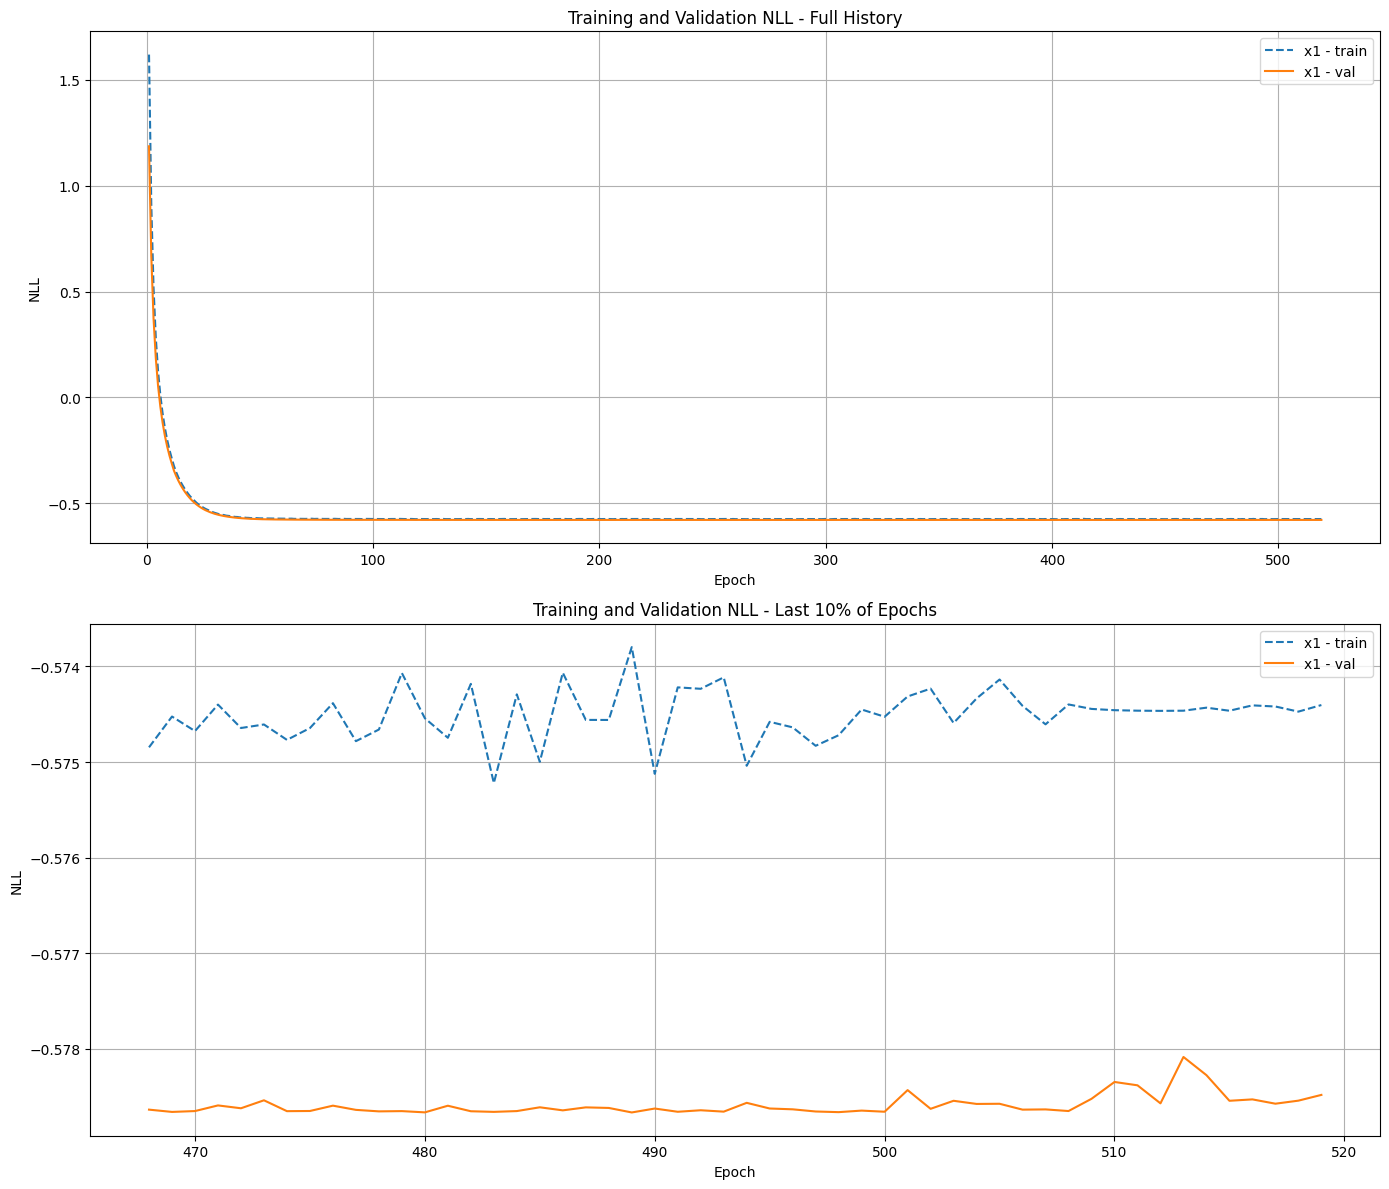

In [60]:
td_model.plot_history('x1')

In [61]:
cfg = TramDagConfig.load("/home/bule/TramDag/dev_experiment_logs/exp_6_2/configuration.json")

create a dedicated TramDagDataset from the pandas dataframe and the config file

In [6]:
# td_train_data=TramDagDataset.from_dataframe(train_df,cfg,device='auto',debug=True)  
# td_val_data=TramDagDataset.from_dataframe(val_df,cfg,shuffle=False,device='auto',debug=True)

create a TramdagModel from the Config file (optionally use COLR POLR as startign values)

In [62]:
td_model = TramDagModel.from_config(cfg, set_initial_weights=False) 

fit the model on the data

In [63]:
td_model.fit(train_df, val_df,epochs=519)


[INFO] Training node 'x1' for 519 epochs on cuda
[INFO] Existing model found. Loading weights and history...

[INFO] Training node 'x2' for 519 epochs on cuda
[INFO] Existing model found. Loading weights and history...

[INFO] Training node 'x3' for 519 epochs on cuda
[INFO] Existing model found. Loading weights and history...


{'x1': None, 'x2': None, 'x3': None}

get latents from a dateset marked as _U

In [64]:
latents_df = td_model.get_latent(train_df)


[INFO] Skipping node 'x3' (ordinal targets not yet supported).
[INFO] Final latent DataFrame shape: (80000, 4)


[INFO] Skipping node 'x3' (ordinal targets not yet supported).
[INFO] Final latent DataFrame shape: (80000, 4)


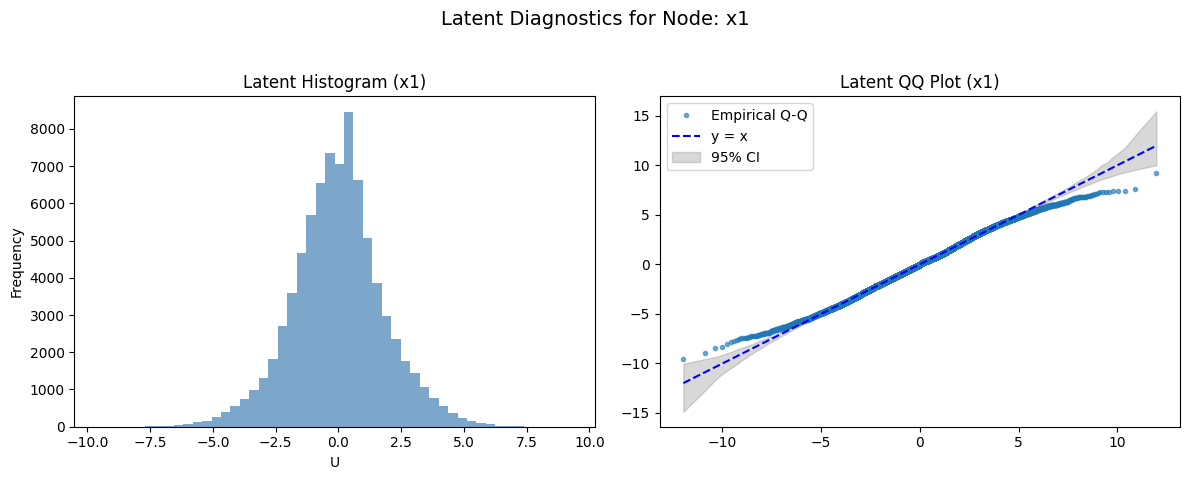

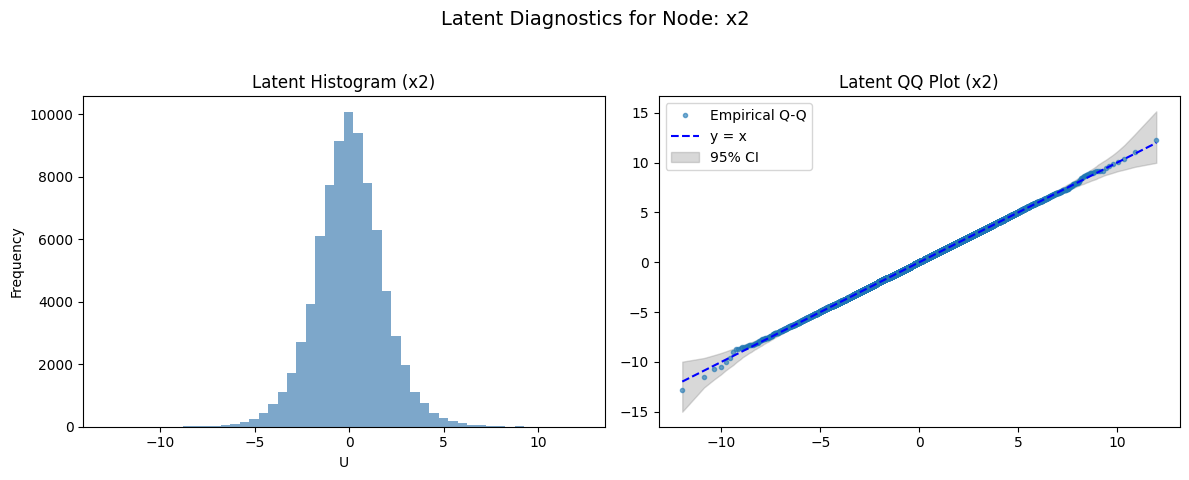

[WARNING] No latent found for node x3, skipping.


In [65]:
td_model.show_latents( train_df)

sample from the whole graph , intervene or use predefined latents

In [10]:
td_model.sample()

Deleted directory: /home/bule/TramDag/dev_experiment_logs/exp_6_2/x1/sampling
Deleted directory: /home/bule/TramDag/dev_experiment_logs/exp_6_2/x2/sampling
Deleted directory: /home/bule/TramDag/dev_experiment_logs/exp_6_2/x3/sampling

----*----------*-------------*--------Sample Node: x1 ------------*-----------------*-------------------*--
[INFO] Sampling new latents for node x1 from standard logistic distribution
[WARNING] target_col 'x1' not in DataFrame columns — is this intended to be used as a Sampler?


Chandrupatla root finding: 100%|██████████| 10000/10000 [00:20<00:00, 490.59it/s]


----*----------*-------------*--------Sample Node: x2 ------------*-----------------*-------------------*--
[INFO] Sampling new latents for node x2 from standard logistic distribution
[WARNING] target_col 'x2' not in DataFrame columns — is this intended to be used as a Sampler?



Chandrupatla root finding: 100%|██████████| 10000/10000 [00:20<00:00, 497.25it/s]


----*----------*-------------*--------Sample Node: x3 ------------*-----------------*-------------------*--
[INFO] Sampling new latents for node x3 from standard logistic distribution
[WARNING] target_col 'x3' not in DataFrame columns — is this intended to be used as a Sampler?


({'x1': tensor([0.7811, 0.1069, 0.7993,  ..., 0.1500, 0.2716, 0.2310]),
  'x2': tensor([-0.1590, -0.1666,  0.0845,  ...,  0.6845, -0.2752, -0.3163]),
  'x3': tensor([1, 1, 1,  ..., 1, 1, 1])},
 {'x1': tensor([ 2.5734, -3.2737,  3.2499,  ..., -2.4392, -0.8847, -1.3168]),
  'x2': tensor([ 0.7773, -0.6050,  2.0391,  ...,  3.7694, -0.8084, -1.0902]),
  'x3': tensor([-1.6195,  2.7791, -0.9229,  ...,  3.8661,  1.9192,  0.5658])})